# Quick Classification Model
### Predicting if I would win a game on Chess.com

In [27]:
from pandas import read_csv
from pandas import get_dummies as gd
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif

### Step # 1: Load Dataset
 - Remove all games that ended in a draw

In [13]:
df = read_csv('../data/use_for_predictions.csv')
df = df[df['result'] != 0.5]

### Step 2: Inspect the data
 - Remove any rows missing values
 - Create dummy columns for categorical values

In [14]:
df.describe()

,result,diff,opp_elo,elo,game_time,color,start_time,day,weekday,day_game_num
count,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000
mean,0.496818,-9.810660,922.616150,912.805489,522.625298,0.502784,14.743835,15.857200,2.856404,3.671042
std,0.500089,101.065052,140.741921,98.828341,139.494102,0.500092,4.548323,8.516872,1.986340,2.808871
min,0.000000,-888.000000,306.000000,679.000000,180.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,-35.000000,838.000000,835.000000,600.000000,0.000000,11.000000,9.000000,1.000000,2.000000
50%,0.000000,-1.000000,913.000000,912.500000,600.000000,1.000000,15.000000,16.000000,3.000000,3.000000
75%,1.000000,32.000000,994.000000,971.750000,600.000000,1.000000,18.000000,23.000000,5.000000,5.000000
max,1.000000,547.000000,1897.000000,1157.000000,600.000000,1.000000,23.000000,31.000000,6.000000,22.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2514 entries, 0 to 2693
Data columns (total 10 columns):
result          2514 non-null float64
diff            2514 non-null int64
opp_elo         2514 non-null float64
elo             2514 non-null float64
game_time       2514 non-null float64
color           2514 non-null int64
start_time      2514 non-null float64
day             2514 non-null int64
weekday         2514 non-null int64
day_game_num    2514 non-null int64
dtypes: float64(5), int64(5)
memory usage: 216.0 KB


In [16]:
df.dropna(inplace=True)
df = gd(df, prefix='gt', drop_first=True, columns=['game_time'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb332741a58>,
      dtype=object)

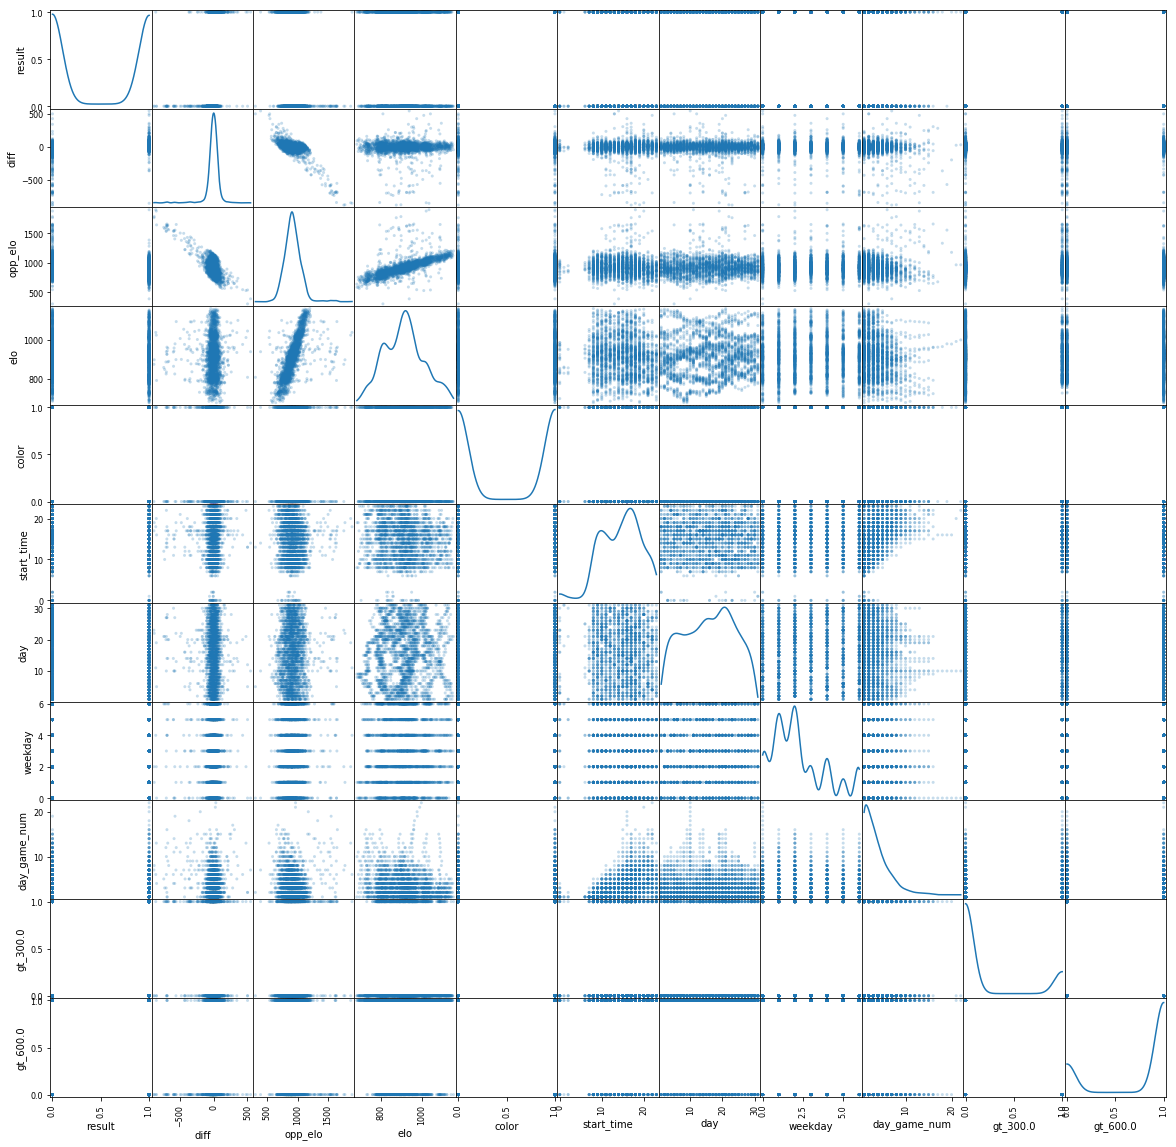

In [19]:
scatter_matrix(df, alpha=0.25, diagonal='kde', grid=True, figsize=(20,20))

In [20]:
df.corr()

,result,diff,opp_elo,elo,color,start_time,day,weekday,day_game_num,gt_300.0,gt_600.0
result,1.000000,0.338943,-0.263948,-0.029276,0.054134,-0.021877,-0.013981,-0.012678,-0.038848,-0.082014,0.093250
diff,0.338943,1.000000,-0.712010,0.008655,-0.022315,0.006641,-0.018469,-0.012654,-0.134644,-0.139810,0.178793
opp_elo,-0.263948,-0.712010,1.000000,0.695980,0.021649,-0.060817,0.047705,0.048281,-0.020854,0.088242,-0.083016
elo,-0.029276,0.008655,0.695980,1.000000,0.008010,-0.079820,0.049049,0.055817,-0.167390,-0.017308,0.064615
color,0.054134,-0.022315,0.021649,0.008010,1.000000,-0.010183,0.008268,0.047072,-0.001189,0.016285,-0.022938
start_time,-0.021877,0.006641,-0.060817,-0.079820,-0.010183,1.000000,-0.026462,-0.003589,0.482045,-0.044438,0.054722
day,-0.013981,-0.018469,0.047705,0.049049,0.008268,-0.026462,1.000000,0.043315,-0.037644,0.034284,-0.000793
weekday,-0.012678,-0.012654,0.048281,0.055817,0.047072,-0.003589,0.043315,1.000000,-0.081789,-0.035417,0.069978
day_game_num,-0.038848,-0.134644,-0.020854,-0.167390,-0.001189,0.482045,-0.037644,-0.081789,1.000000,0.136336,-0.156710
gt_300.0,-0.082014,-0.139810,0.088242,-0.017308,0.016285,-0.044438,0.034284,-0.035417,0.136336,1.000000,-0.878291


### Step 3: Get X & y Values from the dataset
 - Round 1: Tested on all the following X values:
     - Difference in ELO Rating
     - Opponents ELO Rating
     - My ELO rating
     - Game Length
     - Assigned Color
     - Start Time
     - Day of the Month
     - Day of the Week
     - Game Number of the Day
     
 - Dropped following columns based on p-value and feature importance:
     - Day of the Month
     - Day of the Week
     - Game Number of the Day
     - Start Time
     - My ELO rating

In [21]:
y = df['result'].values
X = df.drop(columns=['result', 'day', 'day_game_num', 'weekday', 'elo', 'start_time']).values

### Step 4: Get Training and Test Split, Scale Values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5, shuffle=False)
mmx = StandardScaler().fit(X_train)
X_train = mmx.transform(X_train)
X_test = mmx.transform(X_test)

### Step 5: Use F Classifier to check for p-values
- Go back and remove any columns where p-value is high

In [23]:
fs = SelectPercentile(f_classif, 10).fit(X, y)
print(fs.pvalues_)
print(fs.scores_)

[1.26919956e-68 2.43730194e-41 6.62896057e-03 3.83763512e-05
 2.82107231e-06]
[326.04166139 188.11362772   7.38314543  17.01075818  22.03500758]


### Step 5: Start with Random Forest Ensemble Model
 - Fit the data
 - Predict values

In [24]:
model = RandomForestClassifier(n_estimators=500, max_depth=10,
                               n_jobs=-1, random_state=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

### Step 6: Inspect Results

In [25]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(round(roc_auc_score(y_test, y_pred_prob[:, 1])*100, 2))

              precision    recall  f1-score   support

         0.0       0.64      0.90      0.75        63
         1.0       0.84      0.49      0.62        63

   micro avg       0.70      0.70      0.70       126
   macro avg       0.74      0.70      0.69       126
weighted avg       0.74      0.70      0.69       126

[[57  6]
 [32 31]]
74.45


### Step 8: Check Feature Importance

In [26]:
model.feature_importances_

array([0.59562231, 0.35352845, 0.02285526, 0.01203577, 0.01595822])

### Step 9: Try Another Logistic Model
 - Logistic Regression

In [66]:
model = LogisticRegression(solver='lbfgs', max_iter=500, n_jobs=-1, random_state=5)

In [67]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

In [68]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(round(roc_auc_score(y_test, y_pred_prob[:, 1])*100, 2))

              precision    recall  f1-score   support

         0.0       0.68      0.62      0.65        63
         1.0       0.65      0.71      0.68        63

   micro avg       0.67      0.67      0.67       126
   macro avg       0.67      0.67      0.67       126
weighted avg       0.67      0.67      0.67       126

[[39 24]
 [18 45]]
80.07


### Step 10: Try Another Logistic Model
 - Stochastic Gradient Descent Classifier

In [89]:
model = SGDClassifier(loss='log', max_iter=100000, tol=1e-3,
                      n_jobs=-1, random_state=5)

In [92]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

In [93]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(round(roc_auc_score(y_test, y_pred_prob[:, 1])*100, 2))

              precision    recall  f1-score   support

         0.0       0.72      0.65      0.68        63
         1.0       0.68      0.75      0.71        63

   micro avg       0.70      0.70      0.70       126
   macro avg       0.70      0.70      0.70       126
weighted avg       0.70      0.70      0.70       126

[[41 22]
 [16 47]]
80.42


### Conclusion:
 - Random Forest Classifier - Random Forest Classifier being ensemble algorithm tends to give more accurate result. Working on simple principle of Number of weak estimators when combined forms strong estimator. In our test, it had very few false negatives, but lots of false positives. Even after tuning all the hyper-parameters, the best accuracy score we got was __69.8%__ with an ROC score of __74.5%__.

 - Logistic Regression Classifier - logistic Regression Classifier uses a logistic function to model a binary dependent variable by estimating the odds between two possible values, 0 or 1. After many runs of hyper-parameter tuning, the best model resulted with fewer false positives than Random Forest Classifier, but had considerably high false negatives. Ethe best accuracy score we got was __66.67%__ (2/3) with an ROC score of __80.07%__.
 
 - Stochastic Gradient Descent (SGD) Classifier - Last but not the least of the models we tested. SGD is an iterative method for optimizing a differentiable objective function, a stochastic approximation of gradient descent optimization. This was the trickiest of all to tune. With more hyper-parameters than any other model, it was an iterative process to get the best values. However, IMO SGD did perform the best out of all OOB models. With same accuracy as Random Forest Classifier, __69.8%__, but a much better AUC ROC score, __80.42__.
 
After testing all of the models described, next steps would be to fit a piece-wise regression to get better accuracy predictions. Also, there are abundant number of algorithms available that could be tried, not to mention the Torch and Keras library could also help.